In [171]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from tqdm import tqdm

In [172]:
import time
start_time = time.time()

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

## **String preprocessing function**

In [45]:
def clean_string_name(string):
    text = string.replace(' Size: 4 oz. * USDA Certified Organic Ingredient ** None remains after saponifying oils into soap and glycerin', '')
    pattern = "[\|\*\_\'\{}&]".format('"')
    regex1 = re.compile('\[.*]')
    regex2 = re.compile('\[.*}')
    text = re.sub(pattern, "", text)
    text = re.sub(regex1, "", text)
    text = re.sub(regex2, "", text)
    text = text.strip('\x0c')
    text = text.strip(' ')
    text = text.upper()
    text = text.replace('INACTIVE INGREDIENTS:', '')
    text = text.replace('ACTIVE INGREDIENTS:', '')

    return text

In [46]:
mismatch = ['CAVIAR WATER', 'STEM WATER']
def convert_new_ing_list(x):
    trimed = [name.strip(" '").strip("''") for name in x.strip('[]').split(',')]
    res = ''

    for i in range(len(trimed)):
        if i != (len(trimed) -1):
            if trimed[i] in mismatch:
                res = res + 'WATER' + ', '
            else:
                res = res + trimed[i] + ', '
        else: 
            if trimed[i] in mismatch:
                res = res + 'WATER' + ', '
            else:
                res = res + trimed[i]
    return res

## **Load dataset**

In [139]:
df_skin = pd.read_csv('../Database/EWG/ewg_skin_products_transformed_8208.csv')
df_sun = pd.read_csv('../Database/EWG/ewg_sun_products_transformed_1565.csv')
df_makeup = pd.read_csv('../Database/EWG/ewg_makeup_products_transformed_10527.csv')

df_hair = pd.read_csv('../Database/EWG/ewg_hair_products_transformed_4908.csv')
df_or = pd.read_csv('../Database/EWG/ewg_oralcare_products_transformed_937.csv')
df_frag = pd.read_csv('../Database/EWG/ewg_fragrance_products_transformed_484.csv')

In [140]:
df_all = pd.concat([df_skin, df_sun, df_makeup, df_hair, df_or, df_frag])

### **Cleaning df_all**

In [143]:
df_all.shape

(26625, 9)

In [144]:
df_all.duplicated().sum()

3365

In [145]:
df_all.drop_duplicates(inplace=True)

In [146]:
df_all.reset_index(drop=True, inplace=True)

In [147]:
df_all['product_score'].value_counts()

03          4475
04          4372
02          4327
05          3453
01          2513
verified    1776
06          1520
07           533
08           199
09            56
10            36
Name: product_score, dtype: int64

In [148]:
df_all['new_ing_list_fixed'] = df_all['new_ing_list'].apply(convert_new_ing_list)

In [149]:
df_all['new_product_score'] = df_all['product_score'].map({'verified': 1,
                                                          '01': 2,
                                                          '02': 3,
                                                          '03': 4,
                                                          '04': 5,
                                                          '05': 6,
                                                          '06': 7,
                                                          '07': 8,
                                                          '08': 9,
                                                          '09': 10,
                                                          '10': 10,})

### **Word count**

In [151]:
vocab = Counter()

for ing in df_all['new_ing_list_fixed']:
    for words in ing.split(', '):
        vocab[words] += 1

In [237]:
most_vocab = vocab.most_common(1000)
common_vocab = pd.DataFrame(most_vocab, columns=['word', 'frequency'])

In [238]:
ingredient_idx = {ing[0]: idx for idx, ing in enumerate(most_vocab)}

In [239]:
ingredient_idx

{'WATER': 0,
 'PHENOXYETHANOL': 1,
 'GLYCERIN': 2,
 'IRON OXIDES': 3,
 'TITANIUM DIOXIDE': 4,
 'SILICA': 5,
 'TOCOPHERYL ACETATE': 6,
 'TOCOPHEROL': 7,
 'DIMETHICONE': 8,
 'CITRIC ACID': 9,
 'MICA': 10,
 'CI 77492': 11,
 'CAPRYLYL GLYCOL': 12,
 'CAPRIC TRIGLYCERIDE': 13,
 'CI 77499': 14,
 'ETHYLHEXYLGLYCERIN': 15,
 'GRANITE': 16,
 'SODIUM CHLORIDE': 17,
 'XANTHAN GUM': 18,
 'BUTYROSPERMUM PARKII BUTTER': 19,
 'BUTYLENE GLYCOL': 20,
 'POTASSIUM SORBATE': 21,
 'DISODIUM EDTA': 22,
 'CYCLOPENTASILOXANE': 23,
 'ALOE BARBADENSIS LEAF JUICE': 24,
 'DISTEARDIMONIUM HECTORITE': 25,
 'LIMONENE': 26,
 'COCOS NUCIFERA OIL': 27,
 'SIMMONDSIA CHINENSIS SEED OIL': 28,
 'HELIANTHUS ANNUUS SEED OIL': 29,
 'SODIUM BENZOATE': 30,
 'ISODODECANE': 31,
 'CETEARYL ALCOHOL': 32,
 'LINALOOL': 33,
 'SODIUM HYALURONATE': 34,
 'CETYL ALCOHOL': 35,
 'POLYETHYLENE': 36,
 'PANTHENOL': 37,
 'TRIMETHYLSILOXYSILICATE': 38,
 'TALC': 39,
 'TIN OXIDE': 40,
 'BENZYL ALCOHOL': 41,
 'STEARIC ACID': 42,
 'PROPYLENE CARBONATE

In [240]:
import pickle

# a = {'hello': 'world'}

with open('ingredient_idx_1000.pickle', 'wb') as handle:
    pickle.dump(ingredient_idx, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('ingredient_idx_1000.pickle', 'rb') as handle:
    ingredient_ = pickle.load(handle)


### **Tokenize**

In [241]:
len(ingredient_idx)

1000

In [157]:
df_all['new_ing_list_fixed'][5]

'WATER, BUTYROSPERMUM PARKII BUTTER, AVENA SATIVA KERNEL MEAL'

In [242]:
corpus = []
for i in tqdm(range(len(df_all))):
    ingredients = df_all['new_ing_list_fixed'][i]
#     print(ingredients)
    tokens = ingredients.split(', ')    
    corpus.append(tokens)

100%|██████████| 23260/23260 [00:02<00:00, 7922.77it/s] 


In [249]:
# Define the oh_encoder function
def oh_encoder(tokens):
    x = np.zeros(N)    
    for ingredient in tokens:
        if ingredient in ingredient_idx.keys():
            idx = ingredient_idx[ingredient]
            x[idx] = 1
        else:
            pass
    return x

In [250]:
# Get the number of items and tokens 
M = len(df_all)                 # The number of the items
N = len(ingredient_idx)     # The number of the ingredients

# Initialize a matrix of zeros
A = np.zeros((M, N), dtype=np.uint8)

In [251]:
# Make a document-term matrix
i = 0
for tokens in corpus:
    A[i, :] = oh_encoder(tokens)
    i += 1

In [162]:
# columns name
ingredient_idx_key = [key for key in ingredient_idx.keys()]
df_sorted = pd.DataFrame(A_sorted, columns = ingredient_idx_key) 

# append to the original df
df_vector = pd.concat([df_all, df_sorted], axis=1)

In [163]:
df_vector.to_csv('ewg_all_products_vector.csv', index=False)

In [164]:
df = pd.read_csv('ewg_all_products_vector.csv')

2020-10-20 20:36:29,656 [57789] WARNING  py.warnings:110: [JupyterRequire] /Users/macbookpro/miniconda3/envs/cs_ftmle/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



In [165]:
df_dataset = df.sample(frac=1)
df_dataset.reset_index(drop=True, inplace=True)

In [166]:
df_dataset

,cat_name,subcat_name,product_url,product_brand,product_name,product_score,product_img,ingredient_list,new_ing_list,new_ing_list_fixed,...,OAT AMINO ACIDS,ACACIA FARNESIANA GUM,CYNANCHUM ATRATUM WATER,LINALOOL OXIDE,CYCLOHEXANE,C15 ALCOHOL,DILAURYL THIODIPROPIONATE,HC ORANGE NO. 1,HC VIOLET NO. 1,METHYLCINNAMYL ALCOHOL
0,Skin,Body Wash/Cleanser,https://www.ewg.org/skindeep/products/897154-H...,Healing-Scents,"Shampoo/Body Wash, Juniper Forest",1,https://static.ewg.org/skindeep_images/8971/89...,"distilled water, saponified coconut oil, sapon...","['WATER', 'SULFATED COCONUT OIL', 'ISOMERIZED ...","WATER, SULFATED COCONUT OIL, ISOMERIZED PALM O...",...,0,0,0,0,0,0,0,0,0,0
1,Fragrance,Fragrance For Men,https://www.ewg.org/skindeep/products/886666-G...,Gravity,Spray Cologne,05,https://static.ewg.org/skindeep/img/ewg_missin...,"ALCOHOL DENAT., AQUA/WATER/EAU, PARFUM/FRAGRAN...","['ALCOHOL DENAT.', 'APAFLURANE', 'OCTYLACRYLAM...","ALCOHOL DENAT., APAFLURANE, OCTYLACRYLAMIDE CO...",...,0,0,0,0,0,0,0,0,0,0
2,Oral Care,Toothpaste,https://www.ewg.org/skindeep/products/925217-S...,NaN,Simple Truth Plaque Removing & Whitening Tooth...,02,https://static.ewg.org/skindeep_images/9252/92...,"CALCIUM CARBONATE, GLYCERIN, WATER, XYLITOL, H...","['CALCIUM CARBONATE', 'GLYCERIN', 'WATER', 'XY...","CALCIUM CARBONATE, GLYCERIN, WATER, XYLITOL, H...",...,0,0,0,0,0,0,0,0,0,0
3,Sun,Moisturizer With SPF,https://www.ewg.org/skindeep/products/929215-P...,Paula's Choice,"Calm Mineral Moisturizer, Normal to Oily, SPF 30",3,https://static.ewg.org/skindeep_images/9292/92...,"Active Ingredients: Titanium Dioxide 2.32%, Zi...","['TITANIUM DIOXIDE', 'ETHYLHEXYL PALMITATE', '...","TITANIUM DIOXIDE, ETHYLHEXYL PALMITATE, CYCLOM...",...,0,0,0,0,0,0,0,0,0,0
4,Skin,Bar Soap,https://www.ewg.org/skindeep/products/705390-E...,Em & El Organics,Saving Face Daily Cleansing Bar,2,https://static.ewg.org/skindeep_images/7053/70...,"Saponified Coconut Oil*, Olive Oil*, Almond Oi...","['SULFATED COCONUT OIL', 'OLIVE OIL', 'ALMOND ...","SULFATED COCONUT OIL, OLIVE OIL, ALMOND OIL, S...",...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23255,Hair,Hair Color And Bleaching,https://www.ewg.org/skindeep/products/881597-T...,TRESemme,"R Root Touch Up Temporary Hair Color, Dark Brown",02,https://static.ewg.org/skindeep_images/8815/88...,"BUTANE, HYDROFLUOROCARBON 152A, ETHYL TRISILOX...","['BUTANE', 'HYDROFLUOROCARBON 152A', 'ETHYL TR...","BUTANE, HYDROFLUOROCARBON 152A, ETHYL TRISILOX...",...,0,0,0,0,0,0,0,0,0,0
23256,Makeup,Lipstick,https://www.ewg.org/skindeep/products/780074-P...,Poofy Supernaturals,Stop Traffic Red Matte Lip Velvet,1,https://static.ewg.org/skindeep/img/ewg_missin...,"organic carnauba wax, organic castor oil, orga...","['CARNAUBA ACID WAX', 'OZONIZED CASTOR OIL', '...","CARNAUBA ACID WAX, OZONIZED CASTOR OIL, HYDROG...",...,0,0,0,0,0,0,0,0,0,0
23257,Skin,Mask,https://www.ewg.org/skindeep/products/920646-I...,NaN,I Dew Care See The Light Purifying Vitamin C Mask,5,https://static.ewg.org/skindeep_images/9206/92...,"Water, Dipropylene Glycol, Glycerin, Niacinami...","['WATER', 'DIPROPYLENE GLYCOL', 'GLYCERIN', 'N...","WATER, DIPROPYLENE GLYCOL, GLYCERIN, NIACINAMI...",...,0,0,0,0,0,0,0,0,0,0
23258,Makeup,Lipstick,https://www.ewg.org/skindeep/products/808608-T...,Too Faced,Melted Matte-Tallic Liquified Metallic Matte L...,3,https://static.ewg.org/skindeep_images/8086/80...,"Isododecane, Trimethylolpropane Triisostearate...","['ISODODECANE', 'TRIMETHYLOLPROPANE TRIISOSTEA...","ISODODECANE, TRIMETHYLOLPROPANE TRIISOSTEARATE...",...,0,0,0,0,0,0,0,0,0,0


# **PCA**

In [167]:
from sklearn.decomposition import PCA

In [168]:
df_dataset_cut = df_dataset.iloc[:, 10:]
df_dataset_cut

,new_product_score,WATER,PHENOXYETHANOL,GLYCERIN,IRON OXIDES,TITANIUM DIOXIDE,SILICA,TOCOPHERYL ACETATE,TOCOPHEROL,DIMETHICONE,...,OAT AMINO ACIDS,ACACIA FARNESIANA GUM,CYNANCHUM ATRATUM WATER,LINALOOL OXIDE,CYCLOHEXANE,C15 ALCOHOL,DILAURYL THIODIPROPIONATE,HC ORANGE NO. 1,HC VIOLET NO. 1,METHYLCINNAMYL ALCOHOL
0,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23255,3,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23256,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23257,6,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23258,4,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
y = df_dataset_cut['new_product_score'].to_numpy()
X = df_dataset_cut.iloc[:, 1:].to_numpy(dtype = np.uint8)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [174]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (18608, 7433)
y_train shape:  (18608,)
X_test shape:  (4652, 7433)
y_test shape:  (4652,)


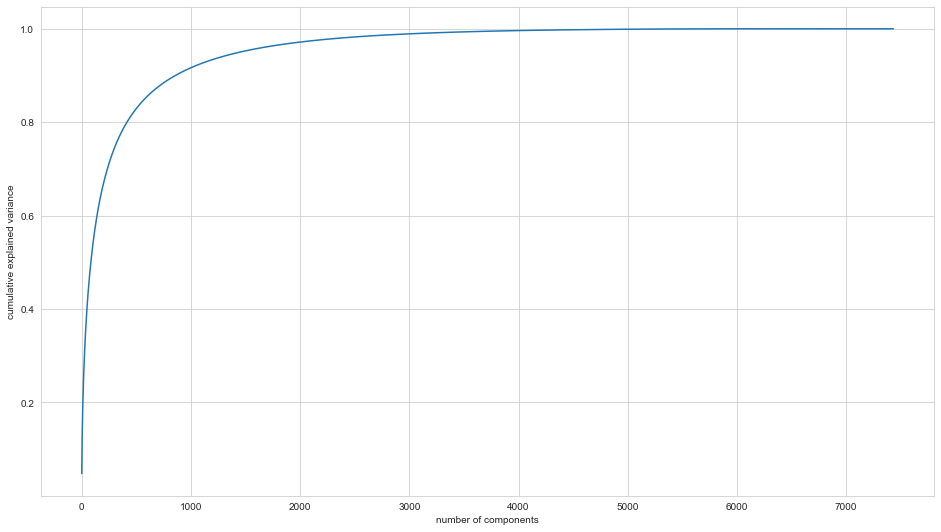

In [175]:
sns.set_style('whitegrid')

pca = PCA().fit(X_train)

plt.figure(figsize=(16, 9))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# **Customize transformer**

In [360]:
df_dataset[['new_ing_list_fixed', 'new_product_score']]

,new_ing_list_fixed,new_product_score
0,"WATER, SULFATED COCONUT OIL, ISOMERIZED PALM O...",2
1,"ALCOHOL DENAT., APAFLURANE, OCTYLACRYLAMIDE CO...",6
2,"CALCIUM CARBONATE, GLYCERIN, WATER, XYLITOL, H...",3
3,"TITANIUM DIOXIDE, ETHYLHEXYL PALMITATE, CYCLOM...",4
4,"SULFATED COCONUT OIL, OLIVE OIL, ALMOND OIL, S...",3
...,...,...
23255,"BUTANE, HYDROFLUOROCARBON 152A, ETHYL TRISILOX...",3
23256,"CARNAUBA ACID WAX, OZONIZED CASTOR OIL, HYDROG...",2
23257,"WATER, DIPROPYLENE GLYCOL, GLYCERIN, NIACINAMI...",6
23258,"ISODODECANE, TRIMETHYLOLPROPANE TRIISOSTEARATE...",4


In [386]:
drop_index = df_dataset[df_dataset['new_ing_list_fixed'].isna()].index.to_list()
df_dataset.drop(drop_index, inplace=True)

AttributeError: 'NoneType' object has no attribute 'reset_index'

In [388]:
# df_dataset.reset_index(drop=True, inplace=True)

In [390]:
X_aaa = column_to_list(df_dataset, 'new_ing_list_fixed')

100%|██████████| 22993/22993 [00:03<00:00, 7471.49it/s] 


In [362]:
X_aaa

[['WATER', 'CINNAMOMUM ZEYLANICUM LEAF OIL'],
 ['SAFFLOWER FLOWER',
  'COCONUT ACID',
  'PALM) FRUIT',
  'SHEA BUTTERATE',
  'WATER',
  'SODIUM HYDROXIDE',
  'ROSA EXTRACT'],
 ['WATER', 'BUTYROSPERMUM PARKII BUTTER', 'AVENA SATIVA KERNEL MEAL'],
 ['WATER',
  'SIMMONDSIA CHINENSIS BUTTER',
  'BUTYROSPERMUM PARKII BUTTER',
  'AVENA SATIVA KERNEL MEAL',
  'LAURALKONIUM CHLORIDE'],
 ['WATER',
  'SIMMONDSIA CHINENSIS BUTTER',
  'LAVANDULA ANGUSTIFOLIA FLOWER OIL',
  'AVENA SATIVA KERNEL MEAL',
  'CINNAMOMUM ZEYLANICUM LEAF OIL'],
 ['WATER', 'BUTYROSPERMUM PARKII BUTTER', 'AVENA SATIVA KERNEL MEAL'],
 ['WATER',
  'PRUNUS AMYGDALUS DULCIS SEED',
  'THEOBROMA CACAO SEED BUTTER',
  'AVENA SATIVA KERNEL MEAL'],
 ['WATER', ''],
 ['WATER',
  'GOAT MILK',
  'HONEY',
  'BUTYROSPERMUM PARKII BUTTER',
  'AVENA SATIVA KERNEL MEAL',
  'CINNAMOMUM ZEYLANICUM LEAF OIL'],
 ['SAFFLOWER FLOWER',
  'COCONUT ACID',
  'PALM) FRUIT',
  'WATER',
  'SODIUM HYDROXIDE',
  'OAT MEAL',
  'CORIANDRUM SATIVUM OIL',
  'E

In [332]:
ingredient_idx

{'WATER': 0,
 'PHENOXYETHANOL': 1,
 'GLYCERIN': 2,
 'IRON OXIDES': 3,
 'TITANIUM DIOXIDE': 4,
 'SILICA': 5,
 'TOCOPHERYL ACETATE': 6,
 'TOCOPHEROL': 7,
 'DIMETHICONE': 8,
 'CITRIC ACID': 9,
 'MICA': 10,
 'CI 77492': 11,
 'CAPRYLYL GLYCOL': 12,
 'CAPRIC TRIGLYCERIDE': 13,
 'CI 77499': 14,
 'ETHYLHEXYLGLYCERIN': 15,
 'GRANITE': 16,
 'SODIUM CHLORIDE': 17,
 'XANTHAN GUM': 18,
 'BUTYROSPERMUM PARKII BUTTER': 19,
 'BUTYLENE GLYCOL': 20,
 'POTASSIUM SORBATE': 21,
 'DISODIUM EDTA': 22,
 'CYCLOPENTASILOXANE': 23,
 'ALOE BARBADENSIS LEAF JUICE': 24,
 'DISTEARDIMONIUM HECTORITE': 25,
 'LIMONENE': 26,
 'COCOS NUCIFERA OIL': 27,
 'SIMMONDSIA CHINENSIS SEED OIL': 28,
 'HELIANTHUS ANNUUS SEED OIL': 29,
 'SODIUM BENZOATE': 30,
 'ISODODECANE': 31,
 'CETEARYL ALCOHOL': 32,
 'LINALOOL': 33,
 'SODIUM HYALURONATE': 34,
 'CETYL ALCOHOL': 35,
 'POLYETHYLENE': 36,
 'PANTHENOL': 37,
 'TRIMETHYLSILOXYSILICATE': 38,
 'TALC': 39,
 'TIN OXIDE': 40,
 'BENZYL ALCOHOL': 41,
 'STEARIC ACID': 42,
 'PROPYLENE CARBONATE

In [338]:
sample = [['WATER', 'PHENOXYETHANOL', 'GLYCERIN', 'IRON OXIDES', 'TITANIUM DIOXIDE'],
         ['TOCOPHERYL ACETATE', 'DIMETHICONE', 'TOCOPHEROL', 'CITRIC ACID']]
met = IngredientTokenizer()
a = met.transform(sample)

In [391]:
from sklearn.base import BaseEstimator, TransformerMixin

class IngredientTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X): # X: nested list
        M = len(X)
        N = 1000
        A = np.zeros((M, N), dtype=np.uint8)
        i= 0
        for ing_list in X:
            x = np.zeros(N, dtype=np.uint8)
            for ingredient in ing_list:
                # Get the index for each ingredient
                if ingredient in ingredient_idx.keys():
                    idx = ingredient_idx[ingredient]
                    x[idx] = 1
                else:
                    pass
            
            A[i, :] = x
            i += 1
        return A

In [343]:
with open('ingredient_idx_1000.pickle', 'rb') as handle:
    ingredient_idx = pickle.load(handle)

In [392]:
def column_to_list(df, col_name):
    corpus = []
    for i in tqdm(range(len(df))):
        
        ingredients = df[col_name][i]
        if not isinstance(ingredients, str):
            print(ingredients)
            ingredients = str(ingredients)
        tokens = ingredients.split(', ')    
        corpus.append(tokens)
    return corpus



In [393]:
X = column_to_list(df_dataset, 'new_ing_list_fixed')
y = df_dataset['new_product_score'].to_numpy()

100%|██████████| 22993/22993 [00:03<00:00, 6622.45it/s]


# **Random Forest**

In [394]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

In [395]:
print('X_train shape: ', len(X_train))
print('y_train shape: ', y_train.shape)
print('X_test shape: ', len(X_test))
print('y_test shape: ', y_test.shape)

X_train shape:  18394
y_train shape:  (18394,)
X_test shape:  4599
y_test shape:  (4599,)


In [428]:
from sklearn.svm import SVC
svc = SVC(C=10, kernel='rbf')

In [429]:
# model_pipeline = Pipeline([
#         ('tokenizer', IngredientTokenizer()),
#         ('scv', RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=250)),
#     ])
model_scv_pipeline = Pipeline([
        ('tokenizer', IngredientTokenizer()),
        ('scv', svc),
    ])

In [430]:
model_scv_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tokenizer', IngredientTokenizer()), ('scv', SVC(C=10))])

In [232]:
# forest_clf = RandomForestClassifier(n_estimators=250, criterion='gini', max_depth=250)
# forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=250, n_estimators=250)

### **Predict**

In [432]:
# Predict on training set
# svc_train_predict = model_scv_pipeline.predict(X_train)
print('Accuracy:', accuracy_score(y_train, svc_train_predict))

Accuracy: 0.9635750788300533


In [433]:
# Predict on test set
svc_test_predict = model_scv_pipeline.predict(X_test)
print('Accuracy:', accuracy_score(y_test, svc_test_predict))

Accuracy: 0.7466840617525549


### **Confusion matrix**

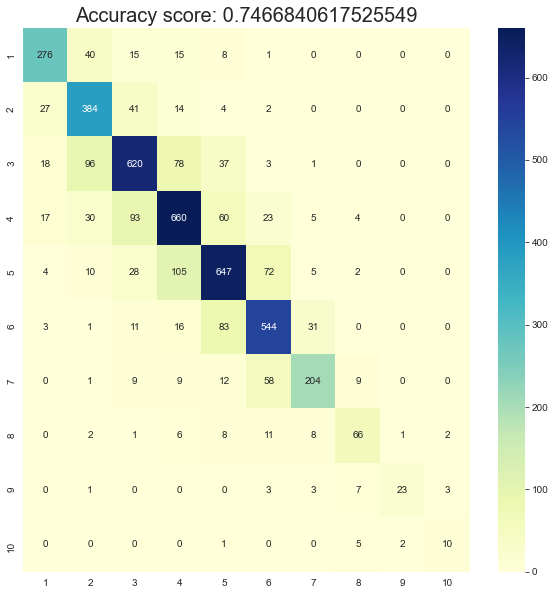

In [434]:
plt.figure(figsize=(10,10))
sns.heatmap(confusion_matrix(y_test, svc_test_predict), cmap="YlGnBu", annot=True, fmt="d",
           xticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
           yticklabels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.title(f'Accuracy score: {accuracy_score(y_test, svc_test_predict)}', fontsize=20)
plt.show()

# **GridSearch**

18394

In [ ]:
parameters = {'scv__kernel': ['poly', 'rbf'],
              'scv__C':[1, 10, 100]}

model_scv_pipeline = Pipeline([
        ('tokenizer', IngredientTokenizer()),
        ('scv', svc),
    ])

gridsearch_svc_models = GridSearchCV(estimator=model_scv_pipeline,
                                 param_grid=parameters,
                                 scoring='accuracy',
                                 n_jobs=-1)

gridsearch_svc_models.fit(X_train, y_train)

In [463]:
model_scv_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tokenizer', 'scv', 'scv__C', 'scv__break_ties', 'scv__cache_size', 'scv__class_weight', 'scv__coef0', 'scv__decision_function_shape', 'scv__degree', 'scv__gamma', 'scv__kernel', 'scv__max_iter', 'scv__probability', 'scv__random_state', 'scv__shrinking', 'scv__tol', 'scv__verbose'])

In [452]:
pd.DataFrame(gridsearch_models.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfc__max_depth,param_rfc__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,48.544055,15.557012,1.409715,0.636390,50,50,"{'rfc__max_depth': 50, 'rfc__n_estimators': 50}",0.710519,0.685784,0.699375,0.680892,0.708809,0.697076,0.011942,42
1,153.740074,2.871632,2.431280,0.331902,50,100,"{'rfc__max_depth': 50, 'rfc__n_estimators': 100}",0.709432,0.694210,0.704267,0.690405,0.724035,0.704470,0.011921,41
2,221.735352,5.542641,2.968964,0.161019,50,150,"{'rfc__max_depth': 50, 'rfc__n_estimators': 150}",0.716771,0.697200,0.708073,0.688230,0.717510,0.705557,0.011358,39
3,276.403001,4.747158,3.905617,0.296505,50,200,"{'rfc__max_depth': 50, 'rfc__n_estimators': 200}",0.713781,0.698831,0.708073,0.692580,0.711800,0.705013,0.008064,40
4,333.050038,1.995736,4.487746,0.140039,50,250,"{'rfc__max_depth': 50, 'rfc__n_estimators': 250}",0.716771,0.697744,0.707529,0.692036,0.719956,0.706807,0.010705,36
5,408.892085,8.193950,5.916279,0.267651,50,300,"{'rfc__max_depth': 50, 'rfc__n_estimators': 300}",0.714325,0.703180,0.707257,0.691220,0.718053,0.706807,0.009373,37
6,80.376786,2.410755,1.706992,0.453973,100,50,"{'rfc__max_depth': 100, 'rfc__n_estimators': 50}",0.717586,0.707257,0.712694,0.691492,0.723763,0.710559,0.010979,31
7,159.943753,5.081917,2.631732,0.259367,100,100,"{'rfc__max_depth': 100, 'rfc__n_estimators': 100}",0.723294,0.704539,0.707529,0.705627,0.722132,0.712624,0.008301,25
8,229.286166,1.755016,3.672802,0.314478,100,150,"{'rfc__max_depth': 100, 'rfc__n_estimators': 150}",0.719217,0.708345,0.714325,0.701006,0.725666,0.713712,0.008530,19
9,307.023461,3.995357,5.921216,0.669593,100,200,"{'rfc__max_depth': 100, 'rfc__n_estimators': 200}",0.723294,0.709976,0.709432,0.703724,0.727569,0.714799,0.009055,14


In [454]:
pd.DataFrame(gridsearch_models.cv_results_)[['mean_fit_time', 'param_rfc__n_estimators', 'param_rfc__max_depth', 'mean_test_score', 'rank_test_score']]

,mean_fit_time,param_rfc__n_estimators,param_rfc__max_depth,mean_test_score,rank_test_score
0,48.544055,50,50,0.697076,42
1,153.740074,100,50,0.704470,41
2,221.735352,150,50,0.705557,39
3,276.403001,200,50,0.705013,40
4,333.050038,250,50,0.706807,36
5,408.892085,300,50,0.706807,37
6,80.376786,50,100,0.710559,31
7,159.943753,100,100,0.712624,25
8,229.286166,150,100,0.713712,19
9,307.023461,200,100,0.714799,14


In [455]:
print('Best params', gridsearch_models.best_params_)
print('Best score', gridsearch_models.best_score_)

Best params {'rfc__max_depth': 150, 'rfc__n_estimators': 250}
Best score 0.7181152348152388


In [459]:
best_rf = gridsearch_models.best_estimator_
test_predict = best_rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, test_predict))

Accuracy: 0.746466623178952


In [460]:


pickle.dump(best_rf, open('rf_grid.pkl', 'wb'))

In [461]:
# Your code here
with open('rf_grid.pkl', 'rb') as model:
    reload_rf = pickle.load(model)

predictions = reload_rf.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')

Accuracy score: 0.746466623178952


# **Save and reload model**

In [424]:
import pickle

pickle.dump(model_pipeline, open('rf_full_pipeline.pkl', 'wb'))

In [426]:
# Your code here
with open('rf_full_pipeline.pkl', 'rb') as model:
    reload_model = pickle.load(model)

predictions = reload_model.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')

Accuracy score: 0.9806479669493368
